In [3]:
import numpy as np

import torch
import torch.nn as nn


# Define the path to the embeddings .npy file
embeddings_npy_path = 'data/embeddings.npy'

# Load the embeddings from the .npy file
title_embeddings = np.load(embeddings_npy_path)

In [4]:
voting_dict = {
    'Y': 0,
    'N': 1,
    'A': 2,
    'X': 3,
}

In [5]:
import pandas as pd
import json

voting_data_path = 'data/UN_DATA.csv'

# read in the data
df = pd.read_csv(voting_data_path)
df['index'] = df.index

print(df)

               Council        Date  \
0     Security Council  2016-12-13   
1     Security Council  2020-06-22   
2     Security Council  2016-12-14   
3     Security Council  2016-12-12   
4     Security Council  2005-09-23   
...                ...         ...   
7850  General Assembly  1976-10-21   
7851  General Assembly  2021-12-06   
7852  General Assembly  2021-12-06   
7853  General Assembly  2021-12-06   
7854  General Assembly  2021-12-06   

                                                  Title        Resolution  \
0     Security Council resolution 2323 (2016) [on ex...  S/RES/2323(2016)   
1     Security Council resolution 2527 (2020) [on ex...  S/RES/2527(2020)   
2     Security Council resolution 2324 (2016) [on Se...  S/RES/2324(2016)   
3     Security Council resolution 2322 (2016) [on in...  S/RES/2322(2016)   
4     Security Council resolution 1627 (2005) [on ex...  S/RES/1627(2005)   
...                                                 ...               ...   
7850

<ipython-input-5-6be2abe57bd6>:7: DtypeWarning: Columns (228,229,230,232,235,236,238,239,240,241,242,243,245,246,247,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(voting_data_path)


In [6]:
title_line = df.columns.values.tolist()

print(title_line)

voters = title_line[11: -1]

voter_embedding_dim = 64
title_projection_dim = 128

['Council', 'Date', 'Title', 'Resolution', 'TOTAL VOTES', 'NO-VOTE COUNT', 'ABSENT COUNT', 'NO COUNT', 'YES COUNT', 'Link', 'token', 'SENEGAL', 'MALAYSIA', 'VENEZUELA (BOLIVARIAN REPUBLIC OF)', 'UNITED KINGDOM', 'RUSSIAN FEDERATION', 'JAPAN', 'ANGOLA', 'URUGUAY', 'SPAIN', 'EGYPT', 'NEW ZEALAND', 'UNITED STATES', 'FRANCE', 'CHINA', 'UKRAINE', 'NIGER', 'SAINT VINCENT AND THE GRENADINES', 'ESTONIA', 'SOUTH AFRICA', 'VIET NAM', 'BELGIUM', 'GERMANY', 'TUNISIA', 'INDONESIA', 'DOMINICAN REPUBLIC', 'BRAZIL', 'UNITED REPUBLIC OF TANZANIA', 'PHILIPPINES', 'ALGERIA', 'BENIN', 'DENMARK', 'ROMANIA', 'ARGENTINA', 'GREECE', 'AUSTRIA', 'SWITZERLAND', 'CYPRUS', 'MOZAMBIQUE', 'SUDAN', 'FIJI', 'BULGARIA', 'CUBA', 'UGANDA', 'ZAMBIA', 'SOUTH SUDAN', 'MONACO', 'REPUBLIC OF KOREA', 'REPUBLIC OF MOLDOVA', 'SAN MARINO', 'YEMEN', 'ITALY', 'BURUNDI', 'HUNGARY', 'CAMBODIA', 'MALAWI', 'NAURU', 'NICARAGUA', 'BRUNEI DARUSSALAM', 'POLAND', 'THAILAND', 'MALDIVES', 'SIERRA LEONE', 'TURKEY', 'CABO VERDE', 'PAPUA NEW GUI

In [7]:

class BaseMLP(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(BaseMLP, self).__init__()

        self.voter_embeddings = nn.Embedding(len(voters), voter_embedding_dim)
        self.proj = nn.Linear(384, title_projection_dim)

        self.fc1 = nn.Linear(title_projection_dim + voter_embedding_dim, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        


    def forward(self, x):
        idx = x[:, -1].long()
        title = x[:, :-1].float()

        voter_embed = self.voter_embeddings(idx)
        title_embed = self.proj(title)

        x = torch.cat((voter_embed, title_embed), dim=1)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        out = self.softmax(x)
        return out

In [8]:
import pandas as pd
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class VoterDataset(Dataset):
    def __init__(self, data):
        self.data = data 
        print('data shape: ', self.data.shape)
        print(data.index)

        self.features = []
        self.labels = []

        # for each line
        for i in tqdm(range(len(self.data))):
            index = self.data.iloc[i]['index']
            cur_line = self.data.iloc[i]
            title_feature = title_embeddings[index]

            for i, voter in enumerate(voters):
                vote = cur_line[voter]

                if vote not in voting_dict:
                    continue

                feature = np.concatenate((title_feature, [i]), 0)

                self.features.append(feature)
                self.labels.append(voting_dict[vote])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
        

In [9]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

train_dataset = VoterDataset(train_data)
valid_dataset = VoterDataset(valid_data)
test_dataset = VoterDataset(test_data)

data shape:  (6284, 271)
Index([6072,  432, 6001, 6308, 2118, 3832, 4398, 1108, 5523, 7678,
       ...
       6265, 5734, 3092, 3772, 5191, 5226, 5390,  860, 7603, 7270],
      dtype='int64', length=6284)


100%|██████████| 6284/6284 [00:16<00:00, 375.24it/s]


data shape:  (785, 271)
Index([6321, 1103, 2897, 1869, 1487,  828, 6353, 4477,  251, 1671,
       ...
       7658, 7847, 4999, 1172, 1242, 7204, 6607, 5260, 3859, 3121],
      dtype='int64', length=785)


100%|██████████| 785/785 [00:01<00:00, 400.69it/s]


data shape:  (786, 271)
Index([4231,  308, 1017, 6682, 6043, 1406,  334, 3194, 4270,  381,
       ...
        425, 5498, 3855, 7836, 5381, 4755, 1407, 4575,  982, 3413],
      dtype='int64', length=786)


100%|██████████| 786/786 [00:01<00:00, 403.12it/s]


In [10]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [12]:
from sklearn.metrics import f1_score

model = BaseMLP(384, 4)

class_weights = torch.tensor([1, 5, 5, 5])
class_weights = class_weights / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.zero_grad()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 10
valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    cnt = 0
    correct = 0
    total = 0
    cur_loss = 0
    for data, target in tqdm(train_loader):
        data, target = data.detach().to(device), target.to(device)
        optimizer.zero_grad()
 
        output = model(data)
        loss = criterion(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        cur_loss += loss.item()

        _ , predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()    

        cnt += 1
        if cnt % 1000 == 0:
            print('Step {} \tTraining Loss: {:.6f} \tAccuracy: {:.6f}'.format(cnt, cur_loss / 1000, correct / total))
            cur_loss = 0
            total = 0
            correct = 0

    model.eval()
    correct = 0
    total = 0
    all_predicted = []
    all_target = []
    for data, target in tqdm(valid_loader):
        data, target = data.detach().to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item() * data.size(0)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        all_predicted.extend(predicted.tolist())
        all_target.extend(target.tolist())

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    accuracy = correct / total
    f1 = f1_score(all_target, all_predicted, average='weighted')
    f1_prime = f1_score(all_target, np.zeros_like(all_predicted), average='weighted')

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    print('Accuracy: {:.6f} \tF1: {:.6f} \tF1 Prime: {:.6f}'.format(accuracy, f1, f1_prime))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_baseline.pt')
        valid_loss_min = valid_loss


  0%|          | 0/11161 [00:00<?, ?it/s]

  9%|▉         | 1029/11161 [00:08<01:06, 151.73it/s]

Step 1000 	Training Loss: 1.220451 	Accuracy: 0.661734


 18%|█▊        | 2030/11161 [00:14<00:58, 156.09it/s]

Step 2000 	Training Loss: 1.177809 	Accuracy: 0.659563


 27%|██▋       | 3025/11161 [00:21<00:53, 152.77it/s]

Step 3000 	Training Loss: 1.168623 	Accuracy: 0.675422


 36%|███▌      | 4015/11161 [00:28<00:46, 154.44it/s]

Step 4000 	Training Loss: 1.155307 	Accuracy: 0.677719


 45%|████▌     | 5023/11161 [00:35<00:41, 148.71it/s]

Step 5000 	Training Loss: 1.155254 	Accuracy: 0.684000


 54%|█████▍    | 6017/11161 [00:42<00:34, 148.60it/s]

Step 6000 	Training Loss: 1.144441 	Accuracy: 0.698422


 63%|██████▎   | 7013/11161 [00:50<01:13, 56.69it/s] 

Step 7000 	Training Loss: 1.153159 	Accuracy: 0.684656


 72%|███████▏  | 8015/11161 [00:58<00:24, 128.93it/s]

Step 8000 	Training Loss: 1.154442 	Accuracy: 0.687203


 81%|████████  | 9022/11161 [01:06<00:14, 148.26it/s]

Step 9000 	Training Loss: 1.154647 	Accuracy: 0.689219


 90%|████████▉ | 10017/11161 [01:13<00:08, 135.47it/s]

Step 10000 	Training Loss: 1.143467 	Accuracy: 0.707391


 99%|█████████▉| 11026/11161 [01:20<00:00, 149.28it/s]

Step 11000 	Training Loss: 1.148913 	Accuracy: 0.696328


100%|██████████| 1422/1422 [00:02<00:00, 478.21it/s]


Epoch: 0 	Training Loss: 1.161144 	Validation Loss: 1.137015
Accuracy: 0.712589 	F1: 0.726518 	F1 Prime: 0.659354
Validation loss decreased (inf --> 1.137015). Saving model ...


  9%|▉         | 1016/11161 [00:07<01:15, 133.56it/s]

Step 1000 	Training Loss: 1.146920 	Accuracy: 0.701859


 18%|█▊        | 2016/11161 [00:14<01:11, 128.31it/s]

Step 2000 	Training Loss: 1.150148 	Accuracy: 0.701859


 27%|██▋       | 3026/11161 [00:22<00:57, 140.81it/s]

Step 3000 	Training Loss: 1.137706 	Accuracy: 0.708375


 36%|███▌      | 4026/11161 [00:28<00:46, 155.08it/s]

Step 4000 	Training Loss: 1.144397 	Accuracy: 0.716187


 45%|████▍     | 5021/11161 [00:35<00:40, 151.11it/s]

Step 5000 	Training Loss: 1.141193 	Accuracy: 0.717734


 54%|█████▍    | 6014/11161 [00:43<00:35, 143.59it/s]

Step 6000 	Training Loss: 1.139028 	Accuracy: 0.718156


 63%|██████▎   | 7015/11161 [00:52<00:50, 82.89it/s] 

Step 7000 	Training Loss: 1.138671 	Accuracy: 0.715375


 72%|███████▏  | 8020/11161 [01:00<00:21, 144.19it/s]

Step 8000 	Training Loss: 1.137246 	Accuracy: 0.709688


 81%|████████  | 9017/11161 [01:08<00:18, 114.22it/s]

Step 9000 	Training Loss: 1.146906 	Accuracy: 0.704922


 90%|████████▉ | 10018/11161 [01:16<00:08, 140.29it/s]

Step 10000 	Training Loss: 1.141443 	Accuracy: 0.709203


 99%|█████████▊| 11016/11161 [01:24<00:01, 136.12it/s]

Step 11000 	Training Loss: 1.137403 	Accuracy: 0.711734


100%|██████████| 1422/1422 [00:02<00:00, 609.34it/s]


Epoch: 1 	Training Loss: 1.141774 	Validation Loss: 1.124041
Accuracy: 0.710852 	F1: 0.728511 	F1 Prime: 0.659354
Validation loss decreased (1.137015 --> 1.124041). Saving model ...


  9%|▉         | 1019/11161 [00:07<01:07, 150.88it/s]

Step 1000 	Training Loss: 1.135442 	Accuracy: 0.705703


 18%|█▊        | 2017/11161 [00:15<01:01, 148.51it/s]

Step 2000 	Training Loss: 1.134734 	Accuracy: 0.703031


 27%|██▋       | 3027/11161 [00:22<00:57, 141.37it/s]

Step 3000 	Training Loss: 1.135340 	Accuracy: 0.704844


 36%|███▌      | 4018/11161 [00:29<00:49, 144.24it/s]

Step 4000 	Training Loss: 1.126705 	Accuracy: 0.716531


 45%|████▍     | 5014/11161 [00:37<00:46, 133.33it/s]

Step 5000 	Training Loss: 1.135223 	Accuracy: 0.714656


 54%|█████▍    | 6018/11161 [00:44<00:36, 139.20it/s]

Step 6000 	Training Loss: 1.125513 	Accuracy: 0.715203


 63%|██████▎   | 7023/11161 [00:52<00:28, 143.68it/s]

Step 7000 	Training Loss: 1.130603 	Accuracy: 0.714359


 72%|███████▏  | 8023/11161 [00:59<00:22, 141.83it/s]

Step 8000 	Training Loss: 1.129429 	Accuracy: 0.715531


 81%|████████  | 9018/11161 [01:06<00:14, 148.40it/s]

Step 9000 	Training Loss: 1.135158 	Accuracy: 0.714875


 90%|████████▉ | 10025/11161 [01:13<00:07, 154.71it/s]

Step 10000 	Training Loss: 1.138591 	Accuracy: 0.713141


 99%|█████████▊| 11013/11161 [01:21<00:01, 137.66it/s]

Step 11000 	Training Loss: 1.134516 	Accuracy: 0.711328


100%|██████████| 1422/1422 [00:02<00:00, 480.78it/s]


Epoch: 2 	Training Loss: 1.132947 	Validation Loss: 1.123199
Accuracy: 0.716413 	F1: 0.731961 	F1 Prime: 0.659354
Validation loss decreased (1.124041 --> 1.123199). Saving model ...


  9%|▉         | 1025/11161 [00:06<01:04, 156.06it/s]

Step 1000 	Training Loss: 1.128937 	Accuracy: 0.721750


 18%|█▊        | 2032/11161 [00:13<00:57, 158.74it/s]

Step 2000 	Training Loss: 1.124285 	Accuracy: 0.724578


 27%|██▋       | 3024/11161 [00:20<00:52, 154.20it/s]

Step 3000 	Training Loss: 1.140421 	Accuracy: 0.726875


 36%|███▌      | 4015/11161 [00:26<00:47, 150.35it/s]

Step 4000 	Training Loss: 1.133965 	Accuracy: 0.727437


 45%|████▍     | 5015/11161 [00:33<00:38, 160.31it/s]

Step 5000 	Training Loss: 1.128982 	Accuracy: 0.727297


 54%|█████▍    | 6021/11161 [00:40<00:31, 161.02it/s]

Step 6000 	Training Loss: 1.132826 	Accuracy: 0.710219


 63%|██████▎   | 7027/11161 [00:48<00:29, 142.37it/s]

Step 7000 	Training Loss: 1.125303 	Accuracy: 0.717500


 72%|███████▏  | 8023/11161 [00:57<00:22, 137.16it/s]

Step 8000 	Training Loss: 1.121330 	Accuracy: 0.725469


 81%|████████  | 9024/11161 [01:03<00:13, 158.25it/s]

Step 9000 	Training Loss: 1.118611 	Accuracy: 0.719484


 90%|████████▉ | 10015/11161 [01:10<00:08, 137.72it/s]

Step 10000 	Training Loss: 1.116658 	Accuracy: 0.705953


 99%|█████████▊| 11012/11161 [01:20<00:01, 95.71it/s] 

Step 11000 	Training Loss: 1.116887 	Accuracy: 0.711609


100%|██████████| 1422/1422 [00:03<00:00, 469.44it/s]


Epoch: 3 	Training Loss: 1.125900 	Validation Loss: 1.108715
Accuracy: 0.712160 	F1: 0.732028 	F1 Prime: 0.659354
Validation loss decreased (1.123199 --> 1.108715). Saving model ...


  9%|▉         | 1026/11161 [00:13<01:14, 136.15it/s]

Step 1000 	Training Loss: 1.120877 	Accuracy: 0.716719


 18%|█▊        | 2027/11161 [00:21<01:22, 110.10it/s]

Step 2000 	Training Loss: 1.129523 	Accuracy: 0.726719


 27%|██▋       | 3017/11161 [00:28<00:54, 150.20it/s]

Step 3000 	Training Loss: 1.125196 	Accuracy: 0.721828


 36%|███▌      | 4004/11161 [00:39<02:16, 52.47it/s] 

Step 4000 	Training Loss: 1.120523 	Accuracy: 0.724609


 45%|████▍     | 5017/11161 [00:47<00:47, 128.67it/s]

Step 5000 	Training Loss: 1.121955 	Accuracy: 0.723344


 54%|█████▍    | 6004/11161 [00:59<00:54, 95.00it/s] 

Step 6000 	Training Loss: 1.130406 	Accuracy: 0.718297


 63%|██████▎   | 7030/11161 [01:08<00:26, 153.06it/s]

Step 7000 	Training Loss: 1.120630 	Accuracy: 0.725297


 72%|███████▏  | 8014/11161 [01:16<00:41, 75.04it/s] 

Step 8000 	Training Loss: 1.126611 	Accuracy: 0.714844


 81%|████████  | 9016/11161 [01:24<00:13, 163.99it/s]

Step 9000 	Training Loss: 1.123426 	Accuracy: 0.717313


 90%|████████▉ | 10018/11161 [01:30<00:07, 148.35it/s]

Step 10000 	Training Loss: 1.117261 	Accuracy: 0.729422


 99%|█████████▉| 11024/11161 [01:36<00:00, 182.34it/s]

Step 11000 	Training Loss: 1.138931 	Accuracy: 0.726984


100%|██████████| 1422/1422 [00:01<00:00, 716.83it/s]


Epoch: 4 	Training Loss: 1.124889 	Validation Loss: 1.120680
Accuracy: 0.659520 	F1: 0.693303 	F1 Prime: 0.659354


  9%|▉         | 1018/11161 [00:07<01:17, 130.64it/s]

Step 1000 	Training Loss: 1.115849 	Accuracy: 0.704984


 18%|█▊        | 2015/11161 [00:13<00:54, 167.92it/s]

Step 2000 	Training Loss: 1.120528 	Accuracy: 0.708656


 27%|██▋       | 3011/11161 [00:23<02:23, 56.62it/s] 

Step 3000 	Training Loss: 1.114537 	Accuracy: 0.708750


 36%|███▌      | 4017/11161 [00:31<00:49, 145.66it/s]

Step 4000 	Training Loss: 1.114909 	Accuracy: 0.706672


 45%|████▍     | 5016/11161 [00:38<00:42, 146.22it/s]

Step 5000 	Training Loss: 1.121688 	Accuracy: 0.717203


 54%|█████▍    | 6032/11161 [00:49<00:34, 150.33it/s]

Step 6000 	Training Loss: 1.115694 	Accuracy: 0.718750


 63%|██████▎   | 7017/11161 [00:56<00:36, 114.73it/s]

Step 7000 	Training Loss: 1.127152 	Accuracy: 0.725281


 72%|███████▏  | 8008/11161 [01:06<00:39, 79.86it/s] 

Step 8000 	Training Loss: 1.122484 	Accuracy: 0.716656


 81%|████████  | 9022/11161 [01:14<00:19, 110.23it/s]

Step 9000 	Training Loss: 1.125600 	Accuracy: 0.714984


 90%|████████▉ | 10021/11161 [01:23<00:07, 145.31it/s]

Step 10000 	Training Loss: 1.122759 	Accuracy: 0.722734


 99%|█████████▉| 11025/11161 [01:30<00:00, 138.21it/s]

Step 11000 	Training Loss: 1.125431 	Accuracy: 0.716297


100%|██████████| 1422/1422 [00:02<00:00, 614.44it/s]


Epoch: 5 	Training Loss: 1.120570 	Validation Loss: 1.113109
Accuracy: 0.723413 	F1: 0.739180 	F1 Prime: 0.659354


  9%|▉         | 1005/11161 [00:08<01:14, 135.89it/s]

Step 1000 	Training Loss: 1.118008 	Accuracy: 0.724234


 14%|█▍        | 1601/11161 [00:13<01:22, 115.80it/s]


KeyboardInterrupt: 

In [19]:
from sklearn.metrics import f1_score

# test
model = BaseMLP(384, 4)
model.load_state_dict(torch.load('model_baseline.pt'))

model.eval()
correct = 0
total = 0
all_predicted = []
all_target = []
for data, target in tqdm(test_loader):
    data, target = data.detach().to(device), target.to(device)

    output = model(data)

    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

    all_predicted.extend(predicted.tolist())
    all_target.extend(target.tolist())



# count numbers of class 0, 1, 2, 3
print('Distribution of classes in test set: ')
print('Class 0: %d' % all_target.count(0))
print('Class 1: %d' % all_target.count(1))
print('Class 2: %d' % all_target.count(2))
print('Class 3: %d' % all_target.count(3))

print('Distribution of classes in prediction: ')
print('Class 0: %d' % all_predicted.count(0))
print('Class 1: %d' % all_predicted.count(1))
print('Class 2: %d' % all_predicted.count(2))
print('Class 3: %d' % all_predicted.count(3))

print('Accuracy on test set: %d %%' % (100 * correct / total))
print('F1 on test set: %f' % f1_score(all_target, all_predicted, average='weighted'))
print('F1 prime on test set: %f' % f1_score(all_target, np.zeros_like(all_predicted), average='weighted'))

# try random guessing
all_predicted_random = np.random.randint(0, 4, len(all_target))
print('F1 random: %f' % f1_score(all_target, all_predicted_random, average='weighted'))


100%|██████████| 1445/1445 [00:03<00:00, 366.71it/s]


Distribution of classes in test set: 
Class 0: 70139
Class 1: 4223
Class 2: 9830
Class 3: 8225
Distribution of classes in prediction: 
Class 0: 60148
Class 1: 3969
Class 2: 16425
Class 3: 11875
Accuracy on test set: 70 %
F1 on test set: 0.724797
F1 prime on test set: 0.654929
F1 random: 0.314968


In [16]:
voter_index = torch.tensor([i for i in range(len(voters))], dtype=torch.long)
initial_embeddings = model.voter_embeddings(voter_index).detach().numpy()
print(initial_embeddings.shape)

(259, 64)


In [26]:
the_five = ['CHINA', 'FRANCE', 'RUSSIAN FEDERATION', 'UNITED KINGDOM', 'UNITED STATES']
g_20 = ['ARGENTINA', 'AUSTRALIA', 'BRAZIL', 'CANADA', 'CHINA', 'FRANCE', 'GERMANY', 'INDIA', 'INDONESIA', 'ITALY', 'JAPAN', 'MEXICO', 'REPUBLIC OF KOREA', 'RUSSIAN FEDERATION', 'SAUDI ARABIA', 'SOUTH AFRICA', 'TURKEY', 'UNITED KINGDOM', 'UNITED STATES']

the_five_index = [voters.index(v) for v in the_five]
g_20_index = [voters.index(v) for v in g_20]

print(the_five_index)

[13, 12, 4, 3, 11]


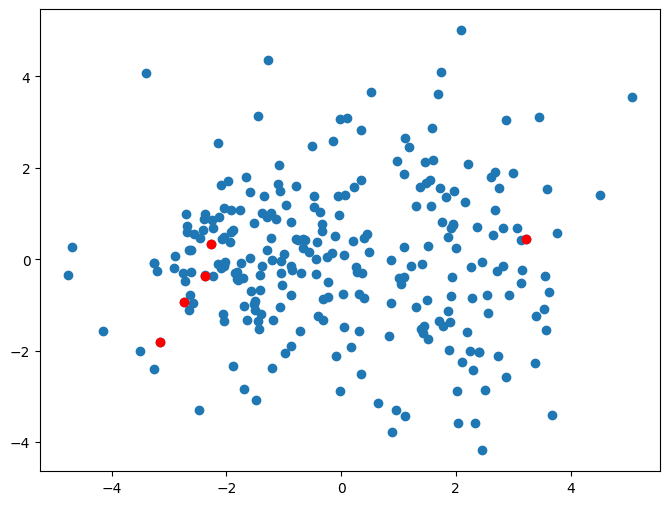

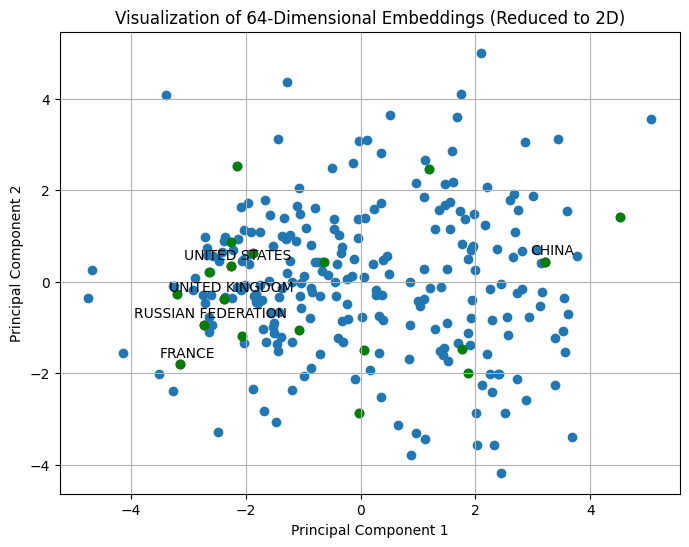

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming initial_embeddings is your (292, 64) array
# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(initial_embeddings)

embedding_2d_five = embeddings_2d[the_five_index]
embedding_2d_g_20 = embeddings_2d[g_20_index]

# Visualize the embeddings in a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='o')

plt.scatter(embedding_2d_five[:, 0], embedding_2d_five[:, 1], marker='o', color='red')
plt.scatter(embedding_2d_g_20[:, 0], embedding_2d_g_20[:, 1], marker='o', color='green')

# Annotating each point with its name
for i, name in enumerate(the_five):
    plt.annotate(name, (embedding_2d_five[i, 0], embedding_2d_five[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')


plt.title('Visualization of 64-Dimensional Embeddings (Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


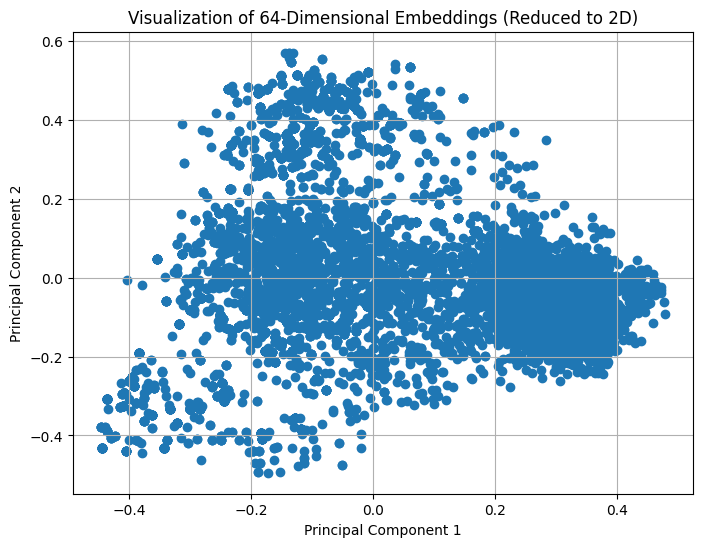

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming initial_embeddings is your (292, 64) array
# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(title_embeddings)

# Visualize the embeddings in a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='o')
plt.title('Visualization of 64-Dimensional Embeddings (Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()